In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
inspector = inspect(engine)
inspector.get_table_names()
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [12]:
from datetime import datetime
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date

first_date = (datetime.strptime(last_date, '%Y-%m-%d').date() - (dt.timedelta(days=365))).strftime('%Y-%m-%d')
first_date

'2016-08-23'

In [13]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >=first_date)\
.filter(Measurement.date <= last_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['Dates', 'Precipitation'])
df.set_index('Dates', inplace=True)
df1= df.dropna()

# Sort the dataframe by date
df2 = df1.sort_values("Dates")

df2.head()

,Precipitation
Dates,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


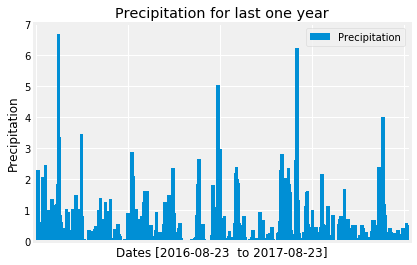

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
from matplotlib.pyplot import figure
import matplotlib.ticker as plticker

ax = df2.plot.bar(title="Precipitation for last one year",width=20.0,grid=True )


#Spacing between each grid line

loc1 = plticker.MultipleLocator(500)
ax.xaxis.set_major_locator(loc1)
# Add the grid
plt.grid(which='major', axis='both', linestyle='-',color='white', linewidth=1)

plt.xlabel("Dates [2016-08-23  to 2017-08-23]")
plt.ylabel("Precipitation")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.savefig("Precip_data.png",dpi=200)
plt.show()


![precipitation](Images/precipitation.png)

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df2.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [16]:
# Design a query to show how many stations are available in this dataset?
count_stations = session.query(func.count(Station.station)).all()
print(count_stations[0][0])

9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.tobs)]
active_stations = session.query(*sel).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.tobs).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == active_stations[0][0]).all()
lowest_temp

[(54.0)]

In [19]:
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == active_stations[0][0]).all()
highest_temp

[(85.0)]

In [20]:
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == active_stations[0][0]).all()
avg_temp

[(71.66378066378067)]

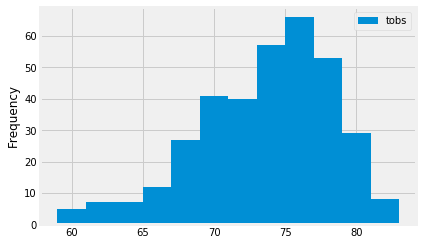

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results1 = session.query(Measurement.tobs)\
                        .filter(Measurement.date >=first_date)\
                        .filter(Measurement.date <=last_date)\
                        .filter(Measurement.station == active_stations[0][0]).all()
final_data = [i[0] for i in results1]
plt.hist(final_data,bins=12,label="tobs")
plt.ylabel('Frequency')
plt.legend()
plt.savefig("Histogram.png",dpi=200)

![precipitation](Images/station-histogram.png)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#first date and last date of the current year has been calculated before, make use of it
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


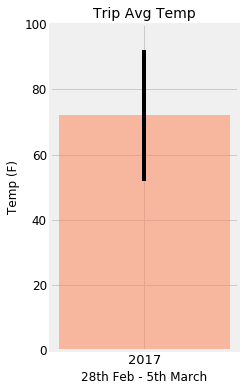

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yavg = calc_temps('2017-02-28', '2017-03-05')[0][1]
yerr = calc_temps('2017-02-28', '2017-03-05')[0][2]-calc_temps(first_date, last_date)[0][0]
plt.figure(figsize=[3, 6])

plt.bar('2017', yavg, yerr=yerr, color='coral', alpha=0.5)


plt.ylabel('Temp (F)', fontsize=12)
plt.xlabel('28th Feb - 5th March')
plt.title('Trip Avg Temp', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(np.arange(0, 120, 20), fontsize=12)
plt.savefig("TripAvgTemp.png",dpi=200)
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,\
       func.sum(Measurement.prcp)]
vacation_data = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= '2017-02-28').\
    filter(Measurement.date <= '2017-03-05').\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
nl = '\n'
for data in vacation_data:
    (station,name,lat,long,elev,rainfall) = data
    print(
    f"Station :{station}{nl}\
    Name :{name}{nl}\
    Station Lat and Long :{lat},{long}{nl}\
    Station Elevation : {elev}{nl}\
    Station Rainfall : {rainfall}{nl}")

Station :USC00519281
    Name :WAIHEE 837.5, HI US
    Station Lat and Long :21.45167,-157.84888999999998
    Station Elevation : 32.9
    Station Rainfall : 4.720000000000001

Station :USC00513117
    Name :KANEOHE 838.1, HI US
    Station Lat and Long :21.4234,-157.8015
    Station Elevation : 14.6
    Station Rainfall : 4.45

Station :USC00516128
    Name :MANOA LYON ARBO 785.2, HI US
    Station Lat and Long :21.3331,-157.8025
    Station Elevation : 152.4
    Station Rainfall : 4.07

Station :USC00517948
    Name :PEARL CITY, HI US
    Station Lat and Long :21.3934,-157.9751
    Station Elevation : 11.9
    Station Rainfall : 2.98

Station :USC00519397
    Name :WAIKIKI 717.2, HI US
    Station Lat and Long :21.2716,-157.8168
    Station Elevation : 3.0
    Station Rainfall : 2.7399999999999998

Station :USC00519523
    Name :WAIMANALO EXPERIMENTAL FARM, HI US
    Station Lat and Long :21.33556,-157.71139
    Station Elevation : 19.5
    Station Rainfall : 2.32

Station :USC005148

## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start ="1/1/2018"
trip_end ="1/7/2018"  
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end)
# Stip off the year and save a list of %m-%d strings
trip_mmdd = trip_dates.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
normals_list = []
for trip_date in trip_mmdd:
    #unpack daily_normals
    normals_list.append(*daily_normals(trip_date))

In [28]:
#make a df
normals_df = pd.DataFrame(normals_list, columns = ['Tmin', 'Tavg', 'Tmax'])

#make the trip dates the index
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')

normals_df

,Tmin,Tavg,Tmax
Date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


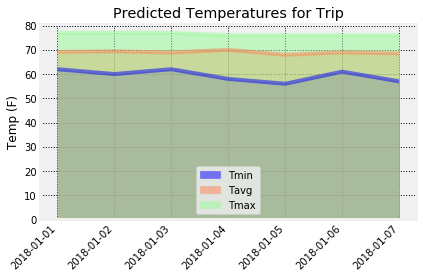

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
'''Area Plot'''

#make a colors list
colors = ['blue', 'coral', 'palegreen']

#make an area plot for the predicted temps
normals_df.plot.area(stacked=False, x_compat=True, color=colors,title='Predicted Temperatures for Trip', rot=45)

#make the labels
plt.xlabel('')
plt.ylabel('Temp (F)')
plt.legend(loc='lower center')
plt.grid(color='black', linestyle='dotted', linewidth=1)
plt.savefig("PredictTemp.png",dpi=200)
plt.show()
